In [11]:
import numpy as np
from sdm.config import get_db_connection
from sdm.utils import clean_text
from sdm.crud_embeddings import get_all_embeddings_clean
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

## Get data from postgres

In [2]:
with get_db_connection(db_type="postgres") as db:
    df = get_all_embeddings_clean(db)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108166 entries, 0 to 108165
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         108166 non-null  int64 
 1   text       108166 non-null  object
 2   doc_type   108166 non-null  object
 3   doc_id     108166 non-null  object
 4   embedding  108166 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.1+ MB


In [3]:
X = df["embedding"].tolist()

In [11]:
scores = []

# elbow method like in data mining
# for n_cluster in range(2, 60, 3):
# for n_cluster in range(2, 12):
for n_cluster in range(50_000, 50_001):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    label = kmeans.labels_
    db_score = davies_bouldin_score(X, label)
    sil_score = silhouette_score(X, label)
    scores.append({
        "K": n_cluster,
        "inertia": kmeans.inertia_,
        "db": db_score,
        "silh": sil_score,
        })

KeyboardInterrupt: 

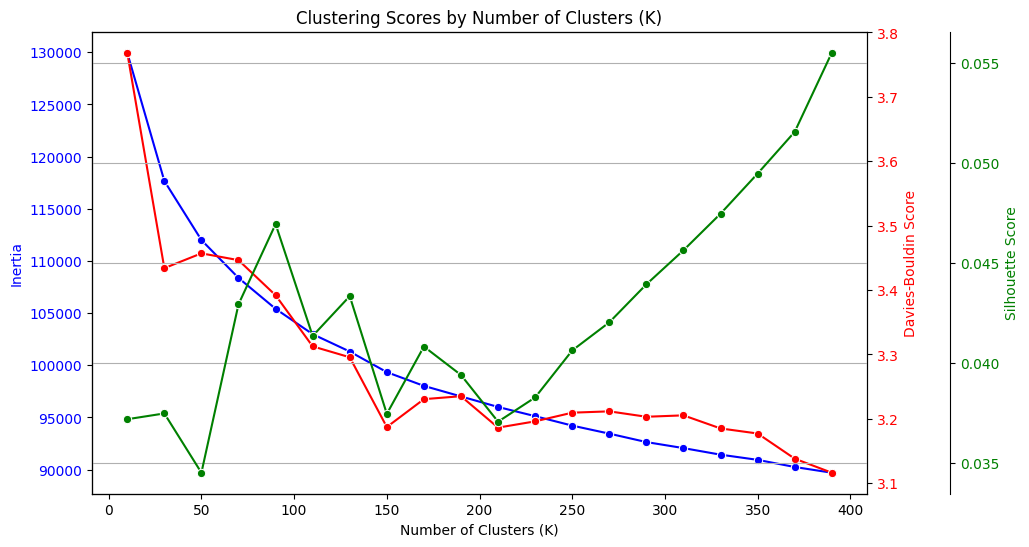

In [7]:
df_scores = pd.DataFrame(scores)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia
sns.lineplot(data=df_scores, x="K", y="inertia", ax=ax1, color="blue", marker="o")
ax1.set_ylabel("Inertia", color="blue")
ax1.set_xlabel("Number of Clusters (K)")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the Davies-Bouldin score
ax2 = ax1.twinx()
sns.lineplot(data=df_scores, x="K", y="db", ax=ax2, color="red", marker="o")
ax2.set_ylabel("Davies-Bouldin Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Create a third y-axis for the Silhouette score
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis to avoid overlap
sns.lineplot(data=df_scores, x="K", y="silh", ax=ax3, color="green", marker="o")
ax3.set_ylabel("Silhouette Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")

plt.title('Clustering Scores by Number of Clusters (K)')
plt.grid(True)
plt.show()

In [4]:
K = 500
kmeans = KMeans(n_clusters=K, random_state=42).fit(X)
labels = kmeans.labels_

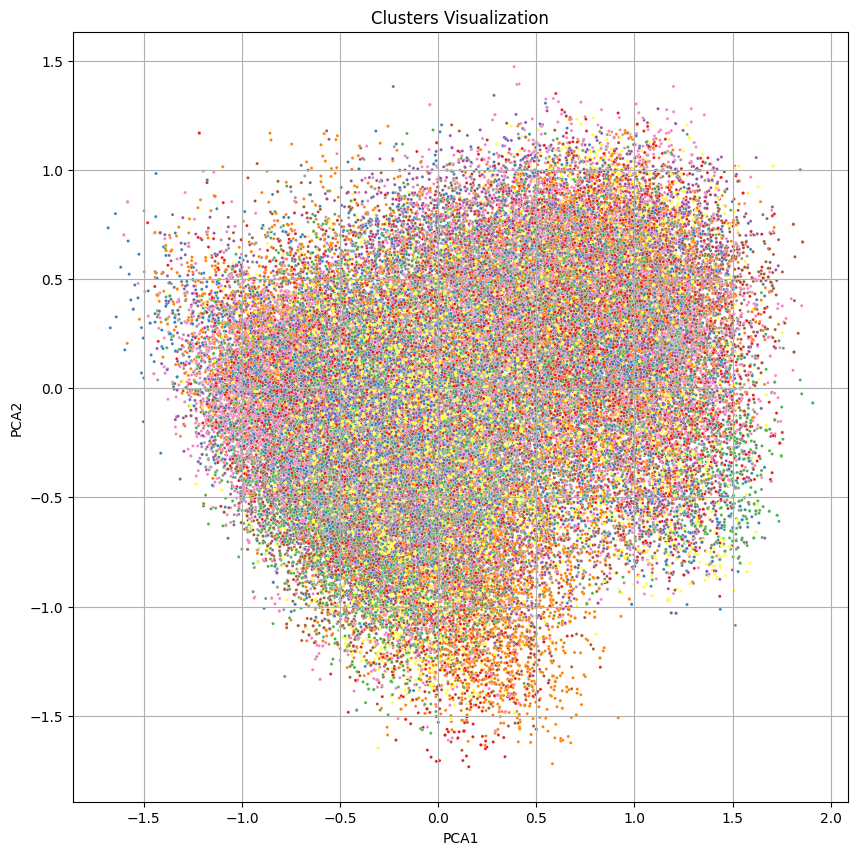

In [5]:
df["labels"] = labels
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df["embedding"].tolist())

# Add reduced components to the dataframe for plotting
df['PCA1'] = X_reduced[:, 0]
df['PCA2'] = X_reduced[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PCA1', y='PCA2', hue='labels', palette='Set1', data=df, s=5, legend=False)
plt.title('Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [6]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(np.array(df["embedding"].tolist())) # tsne does not like list of lists :/

df['TSNE1'] = X_reduced[:, 0]
df['TSNE2'] = X_reduced[:, 1]

## Plot Clusters

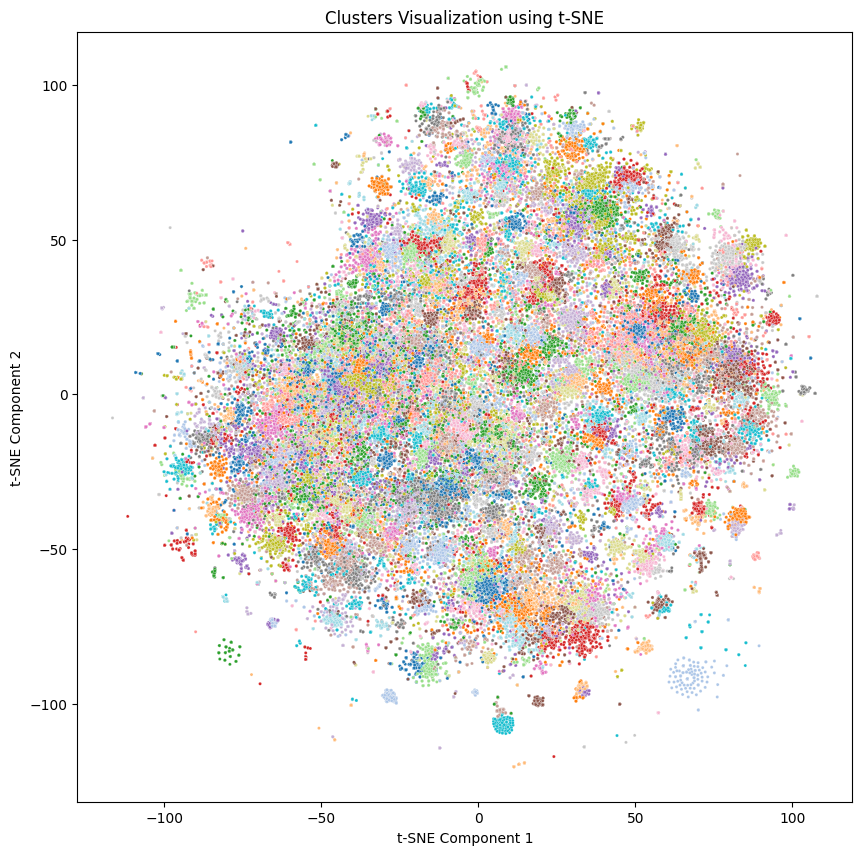

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='labels', palette='tab20', data=df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Compare by platform/doctype

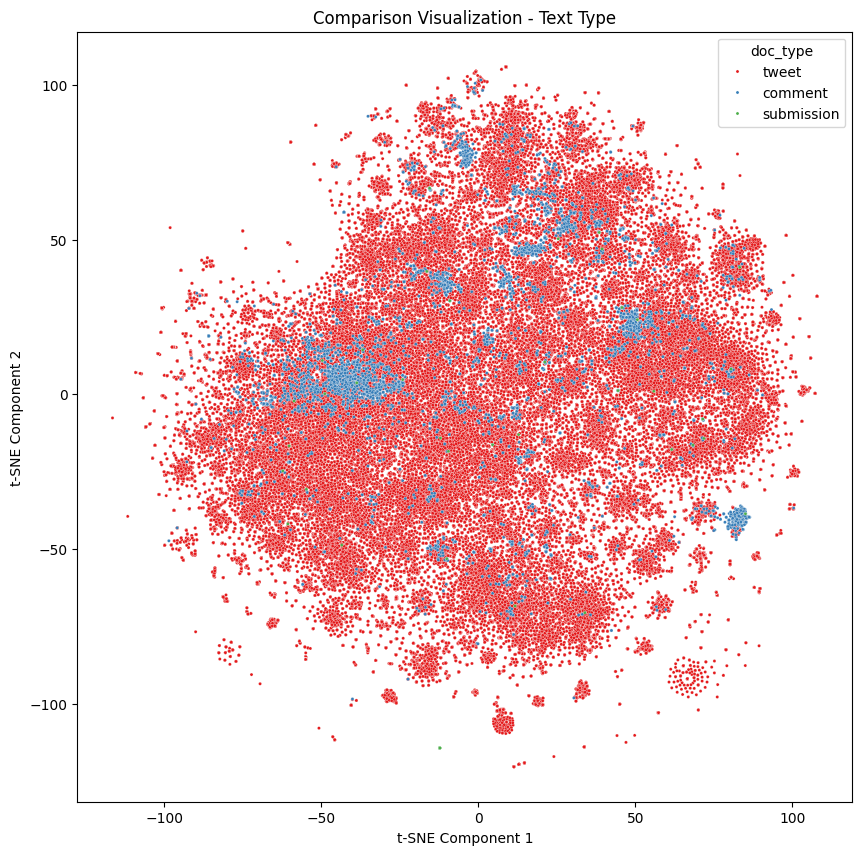

In [8]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='doc_type',
                     palette="Set1",
                     data=df, s=5, legend=True)

plt.title('Comparison Visualization - Text Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

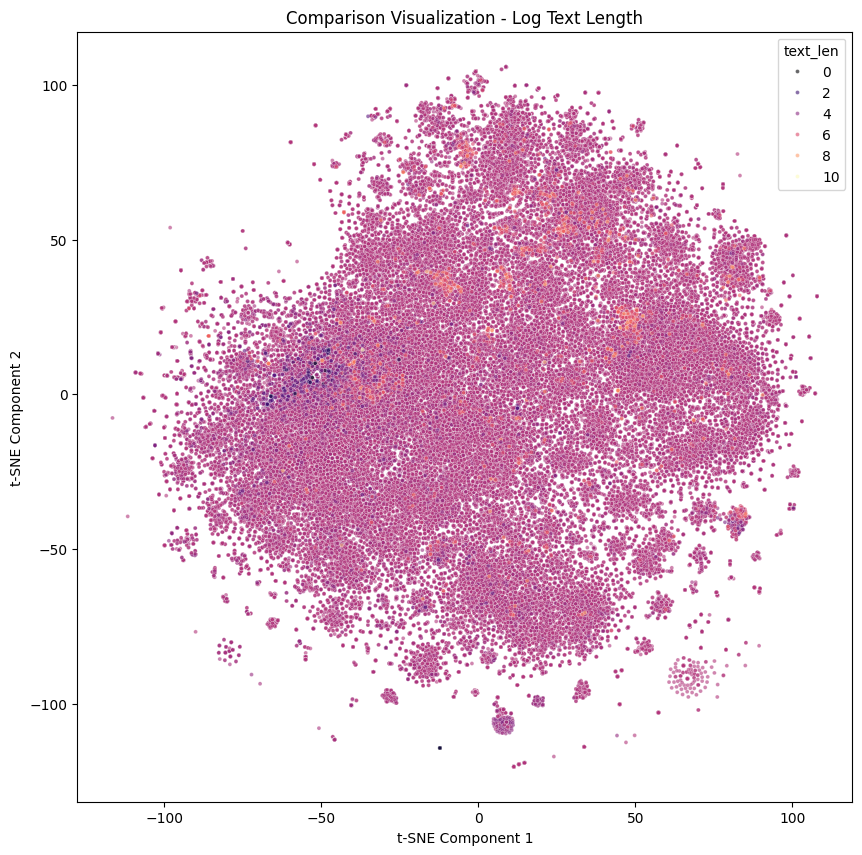

In [9]:
df["text_len"] = df["text"].apply(lambda x: np.log(len(x)))
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="TSNE1", y="TSNE2", hue="text_len",
                     palette="magma",
                     data=df, s=8, alpha=0.6, legend=True)

plt.title("Comparison Visualization - Log Text Length")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Intruder detection

In [33]:
# TODO add to lib
def intruder_detection(df, num_samples=3):
    cluster = df['labels'].sample(n=1).values[0]
    same_cluster_samples = df[df['labels'] == cluster].sample(n=2, random_state=42)
    different_cluster_samples = df[df['labels'] != cluster].sample(n=1, random_state=42)
    intruder_group = pd.concat([same_cluster_samples, different_cluster_samples])
    for _, row in intruder_group.sample(frac=1).iterrows():
        print(f"Text from Cluster {row['labels']}, Platform: {row['doc_type']}")
        print(f"{row['text']}")
        print(f"CLEANED: {clean_text(row['text'])}")
        print('-'*50)

intruder_detection(df)

Text from Cluster 398, Platform: tweet
RT @Ed_Crooks: Presidents Obama and Putin meet at #COP21, picture speaks for itself: https://t.co/7QBoOTKfTM
CLEANED: Presidents Obama and Putin meet at , picture speaks for itself:
--------------------------------------------------
Text from Cluster 398, Platform: tweet
#COP21: Obama talks to Putin, expresses regret over downed Su-24 jet in Syria - Kremlin https://t.co/P6OwbrYdLi https://t.co/ObQAkONEo1
CLEANED: : Obama talks to Putin, expresses regret over downed Su-24 jet in Syria - Kremlin
--------------------------------------------------
Text from Cluster 202, Platform: tweet
'Keep Fossil Fuels in the Ground: A Declaration for the Health of Mother Earth' https://t.co/Pd6hY0hHc0 #COP21 https://t.co/1tkeSs3ikk
CLEANED: 'Keep Fossil Fuels in the Ground: A Declaration for the Health of Mother Earth'
--------------------------------------------------


In [62]:
temp = df.groupby("labels")["id"].count()
temp

labels
0      194
1      254
2      215
3      624
4      135
      ... 
495    291
496    137
497    265
498    195
499    219
Name: id, Length: 500, dtype: int64

## Shannon entropy as measurement of mixture in clusters

Median entropy: 0.07724365447459824
Total count of labels with a mix of doc_types: 328


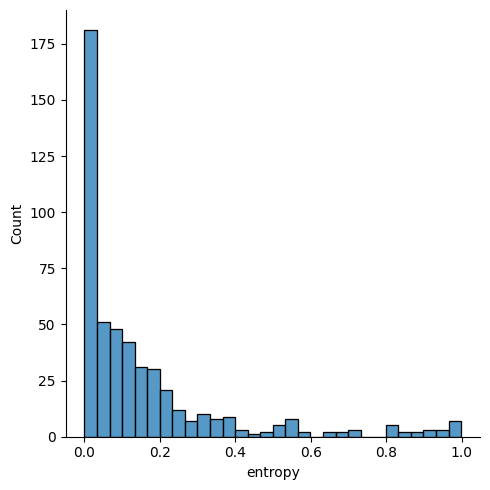

In [48]:
from scipy.stats import entropy

def shannon_entropy(cluster: pd.Series):
    _, counts = np.unique(cluster, return_counts=True)
    return entropy(counts, base=2)

df["entropy"] = df.groupby("labels")["doc_type"].transform(shannon_entropy)
sns.displot(df[['labels', 'entropy']].drop_duplicates()["entropy"], bins=30)
avg_entropy = np.median(df[['labels', 'entropy']].drop_duplicates()['entropy'])
print(f"Median entropy: {avg_entropy}")
label_doc_type_counts = df.groupby('labels')['doc_type'].nunique()
mixed_labels = label_doc_type_counts[label_doc_type_counts > 1]
print("Total count of labels with a mix of doc_types:", mixed_labels.count())

## Fun clusters

Topic 398 with K=500, random state 42: _Obama + putin_

In [34]:
for _, x in df[df["labels"] == 398].iterrows():
    print("--"*20)
    print(x["text"])

----------------------------------------
RT @ClimateHome: Narendra Modi is happy with the Paris deal, say Indian negotiators: https://t.co/eaIk8NPxuk #COP21
----------------------------------------
Narendra Modi is happy with the Paris deal, say Indian negotiators: https://t.co/eaIk8NPxuk #COP21
----------------------------------------
#ANI_news As #COP21 enters final stage, President Hollande called PM Narendra Modi to apprise him of latest status. PM appreciated the gest…
----------------------------------------
#ndtv As #COP21 enters final stage, President Hollande calls PM Narendra Modi to apprise him of latest status. PM appreciated the gesture: …
----------------------------------------
As #COP21 enters final stage, President Hollande calls PM Narendra Modi to apprise him of latest status. PM appreciated the gesture: MEA
----------------------------------------
RT @PeteOgden: This follows Pres. Obama's #COP21 calls earlier this week with PM Modi, Pres. Hollande, and Pres. Roussef

__Polar Bears__:
K=500, random = 42.
- label 102 (mix of tweets but mostly reddit)
- label 229 (50/50 reddit/twitter)

In [46]:
for _, x in df[df["labels"] == 102].iterrows():
    print("--"*10, x["doc_type"])
    print(x["text"])

-------------------- tweet
"@IsabiRomano: Orsi polari contro il riscaldamento globale @350 #D12 #Paris #COP21 @RaiNews https://t.co/71thMRBNzB"
-------------------- tweet
"We know the polar bears are hurting" - the Gwich'in tribe have lived in balance with them for 1000s of yrs #COP21 https://t.co/TUxO0KzkIY
-------------------- tweet
.@Greenpeace polar bear here reminding negotiators #COP21 its not only people who face irreversible loss &amp; damage https://t.co/Gh8QxRvnxf
-------------------- tweet
#climatechange is not just a challenge for polar bears (although likes them), but it is a challenging for our children @GinaEPA #COP21
-------------------- tweet
Melting sea ice = shrinking homes for the polar bear. We need #climateaction: https://t.co/hEj4pV6AkG #COP21 https://t.co/zCpJABXdVB
-------------------- tweet
RT @OECD_ENV: Martin Frick @FAOclimate: we’re not talking about polar bears losing their lives, we’re talking about human beings  #COP21
-------------------- tweet
Martin F

__Money/Finance__:
- label 113

In [ ]:
for _, x in df[df["labels"] == 113].iterrows():
    print("--"*10, x["doc_type"])
    print(x["text"])

-------------------- tweet
@SteveSGoddard Strong corruption with #climatechange We're saved!

#COP21
-------------------- tweet
@tvanouvelles pas important. #COP21 @UN sont verdoyants et nous taxeront plus #polcan  https://t.co/sqOVGQQPQl
-------------------- tweet
@tvanouvelles rien de grave, nos élus nous ont fait payés #COP21 avec l'accord de @UN #polcan  https://t.co/DIZvXOKEdz
-------------------- tweet
@suzannen2014 menteurs très bien payés pour nous voler nos $ durement gagnés #COP21 @s_guilbeault @UN
-------------------- tweet
Les riches peuvent quitter #COP21 @tvanouvelles @RadioCanadaInfo @LeDevoir @LP_LaPresse https://t.co/opAHnho5Hp
-------------------- tweet
Great ! Nous avons ouvert la collusion et la corruption au monde entier #COP21 @UN #polcan #polqc  https://t.co/gAFcdUBxQg
-------------------- tweet
No more excuses. The cost of inaction it's unbearable #COP21  https://t.co/A26Z0cj94o
-------------------- tweet
Savings tables «  Meat The Truth #COP21 #klimaatakkoord h

__Education/Learning__:
- Label 0

In [63]:
for _, x in df[df["labels"] == 0].iterrows():
    print("--"*10, x["doc_type"])
    print(x["text"])

-------------------- tweet
RT @JonOuaretGave: #ClimateJusticePeace #COP21 #CliMates_ Mobilization in the 13th district for "Education" ! https://t.co/KKKG149XnF
-------------------- tweet
RT @UNESCO: We have to educate people about #climatechange - @IrinaBokova #EarthToParis #COP21
-------------------- tweet
RT @UNESCO: ASPnet mobilizing schools on #climatechange #COP21  https://t.co/hifqpvtKgt
-------------------- tweet
RT @UNDP: Online games teach energy efficiency to #Turkey's youth,so they can study AND play: https://t.co/hf5Du3g3F3 #COP21 https://t.co/H…
-------------------- tweet
Online games teach energy efficiency to #Turkey's youth,so they can study AND play: https://t.co/hf5Du3g3F3 #COP21 https://t.co/H3C7OaEje9
-------------------- tweet
RT @larutadelclima: Somos parte de @larutadelclima. Impulsando educación y comunicación inclusiva #cambioclimatico #cop21 #COP21RutaLAC htt…
-------------------- tweet
RT @KDavisClimate: California and Germany have become learning hubs for #